In [58]:
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

import modern_robotics as mr

import networkx as nx

from description.kinematics import JointPoint

In [45]:
cassie_graph = nx.Graph()
# https://cad.onshape.com/documents/52eb11422c701d811548a6f5/w/655758bb668dff773a0e7c1a/e/77ff7f84e82d8fb31fe9c30b
# abs_ground = np.array([0.065, 0, -0.015])
abs_ground = np.array([0.065, 0, -0.047])
pos_toeA_joint = np.array([0.065, 0, -0.047]) - abs_ground
pos_toeA_tarus_joint = np.array([-0.273, 0, -0.350]) - abs_ground
pos_shin_joint = np.array([0.021, 0, -0.159]) - abs_ground
pos_knee_spring = np.array([0.011, 0, -0.219]) - abs_ground
pos_tarus_joint = np.array([-0.237, 0, -0.464]) - abs_ground
pos_foot_joint = np.array([-0.080, 0, -0.753]) - abs_ground
pos_molet_joint = np.array([-0.207, 0, -0.552]) - abs_ground
pos_toeB_joint = np.array([-0.257, 0, -0.579]) - abs_ground
pos_toeB_foot_joint = np.array([-0.118, 0, -0.776]) - abs_ground

ground_joint = JointPoint(pos=np.zeros(3), attach_ground=True, active=True)
shin_joint = JointPoint(pos=pos_shin_joint, active=True)
knee_spring = JointPoint(pos_knee_spring, weld=True)
tarus_joint = JointPoint(pos=pos_tarus_joint)
foot_joint = JointPoint(pos=pos_foot_joint)

toeA_joint = JointPoint(pos=pos_toeA_joint)
connect_toeA_tarus_joint = JointPoint(pos=pos_toeA_tarus_joint, weld=True)

molet_joint = JointPoint(pos=pos_molet_joint, active=True)
toeB_joint = JointPoint(pos=pos_toeB_joint)
toeB_foot_joint = JointPoint(pos=pos_toeB_foot_joint)

joints = [ground_joint, shin_joint, knee_spring, tarus_joint, foot_joint, toeA_joint, connect_toeA_tarus_joint,
            molet_joint, toeB_joint, toeB_foot_joint]

for j in joints:
    cassie_graph.add_node(j)
main_branch = [ground_joint, shin_joint, knee_spring, tarus_joint, foot_joint]
add_branch_1 = [[ground_joint,shin_joint], toeA_joint, connect_toeA_tarus_joint, [tarus_joint,foot_joint]]
add_branch_2 = [[tarus_joint,foot_joint], molet_joint, toeB_joint, toeB_foot_joint, foot_joint]

In [46]:
for id in range(len(main_branch)-1):
    cassie_graph.add_edge(main_branch[id],main_branch[id+1], variable = False, active = False, weight = 1)
for id in range(len(add_branch_1)-1):
    if isinstance(add_branch_1[id], list):
        for j in add_branch_1[id]:
            cassie_graph.add_edge(j,add_branch_1[id+1], variable = False, active = False, weight = 1)
    elif isinstance(add_branch_1[id+1], list):
        for j in add_branch_1[id+1]:
            cassie_graph.add_edge(j,add_branch_1[id], variable = False, active = False, weight = 1)
    else:
            cassie_graph.add_edge(add_branch_1[id],add_branch_1[id+1], variable = False, active = False, weight = 1)
for id in range(len(add_branch_2)-1):
    if isinstance(add_branch_2[id], list):
        for j in add_branch_2[id]:
            cassie_graph.add_edge(j,add_branch_2[id+1], variable = False, active = False, weight = 1)
    elif isinstance(add_branch_2[id+1], list):
        for j in add_branch_2[id+1]:
            cassie_graph.add_edge(j,add_branch_2[id], variable = False, active = False, weight = 1)
    else:
            cassie_graph.add_edge(add_branch_2[id],add_branch_2[id+1], variable = False, active = False, weight = 1)

In [47]:
pos = {}
for node in cassie_graph:
    pos[node] = [node.pos[0],node.pos[2]]

In [48]:
pos

{JointPoint(pos=array([0., 0., 0.]), weld=False, active=True, attach_ground=True, attach_endeffector=False, instance_counter=0): [0.0,
  0.0],
 JointPoint(pos=array([-0.044,  0.   , -0.112]), weld=False, active=True, attach_ground=False, attach_endeffector=False, instance_counter=0): [-0.044,
  -0.112],
 JointPoint(pos=array([-0.054,  0.   , -0.172]), weld=True, active=False, attach_ground=False, attach_endeffector=False, instance_counter=0): [-0.054000000000000006,
  -0.172],
 JointPoint(pos=array([-0.302,  0.   , -0.417]), weld=False, active=False, attach_ground=False, attach_endeffector=False, instance_counter=0): [-0.302,
  -0.41700000000000004],
 JointPoint(pos=array([-0.145,  0.   , -0.706]), weld=False, active=False, attach_ground=False, attach_endeffector=False, instance_counter=0): [-0.14500000000000002,
  -0.706],
 JointPoint(pos=array([0., 0., 0.]), weld=False, active=False, attach_ground=False, attach_endeffector=False, instance_counter=0): [0.0,
  0.0],
 JointPoint(pos=arr

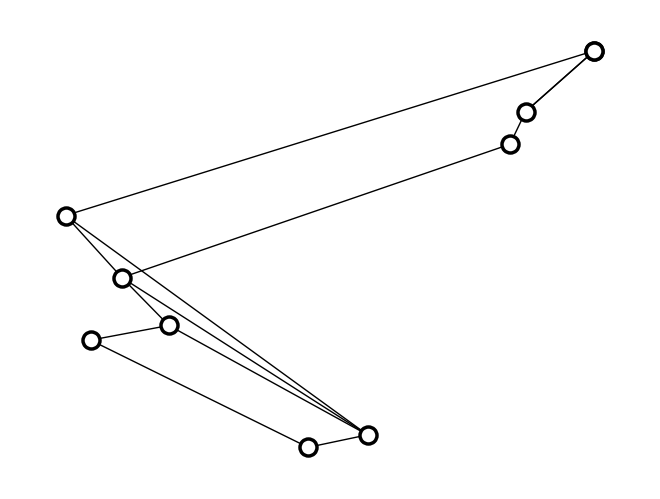

In [51]:
nx.draw(cassie_graph, pos, node_color="w", linewidths=2.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)

In [123]:
def get_rot_matrix_by_vec(v):
    ez = np.array([0,0,1])
    ex = np.array([1,0,0])
    # axis = np.sign(np.inner(ex, v)) * mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v)
    axis = mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v)
    angle = np.arccos(np.inner(ez, v) / la.norm(ez) / la.norm(v))
    out = lambda q: R.from_rotvec(axis * (angle + np.sign(np.inner(ex, v)) * q), )
    print(axis, mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v), angle)
    return out 

In [136]:
ez = np.array([0,0,1])
ex = np.array([1,0,0])

v1z = main_branch[1].pos - main_branch[0].pos

In [433]:
R1 = get_rot_matrix_by_vec(v1z)

H_w_b1 = np.eye(4)
H_w_b1[:3,:3] = R1(0).as_matrix()

[ 0. -1.  0.] [ 0. -1.  0.] 2.767259037582209


In [434]:
v2z = main_branch[2].pos - main_branch[1].pos

v2z_l = la.inv(H_w_b1) @ np.array([*v2z.tolist(), 1])

R2 = get_rot_matrix_by_vec(v2z_l[:3])

H_b1_b2 = np.eye(4)
H_b1_b2[:3,:3] = R2(0).as_matrix()
H_b1_b2[:3,3] = np.array([0,0,la.norm(v1z)])

[ 0. -1.  0.] [ 0. -1.  0.] 0.20918493859295728


In [435]:
v3z = main_branch[3].pos - main_branch[2].pos

# v3z_l = R2(0).as_matrix().T @ R1(0).as_matrix().T @ v3z
v3z_l = la.inv(H_b1_b2) @ la.inv(H_w_b1) @ np.array([*v3z.tolist(), 1])


R3 = get_rot_matrix_by_vec(v3z_l[:3])

H_b2_b3 = np.eye(4)
H_b2_b3[:3,:3] = R3(0).as_matrix()
# H_b2_b3[:3,3] = v2z_l
H_b2_b3[:3,3] = np.array([0,0,la.norm(v2z)])

[0. 1. 0.] [0. 1. 0.] 0.8278952563080412


In [436]:
v3z_l, v3z

(array([0.1793593 , 0.        , 0.16472779, 1.        ]),
 array([-0.248,  0.   , -0.245]))

In [437]:
q1 = 0
q2 = 0
q3 = 0

H_w_b1 = np.eye(4)
H_w_b1[:3,:3] = R1(q1).as_matrix()
# H_w_b1[:3,3] = np.array([0,0,la.norm(v1z)])

H_b1_b2 = np.eye(4)
H_b1_b2[:3,:3] = R2(q2).as_matrix()
H_b1_b2[:3,3] = np.array([0,0,la.norm(v1z)])
# H_b1_b2[:3,3] = np.array([0,0,la.norm(v2z)])
# H_b1_b2[:3,3] = v1z

H_b2_b3 = np.eye(4)
H_b2_b3[:3,:3] = R3(q3).as_matrix()
# H_b2_b3[:3,3] = v2z_l
H_b2_b3[:3,3] = np.array([0,0,la.norm(v2z)])
# H_b2_b3[:3,3] = np.array([0,0,0])

In [438]:
H_b2_b3, R3(q3).as_matrix()

(array([[ 0.67642742,  0.        ,  0.7365093 ,  0.        ],
        [ 0.        ,  1.        ,  0.        ,  0.        ],
        [-0.7365093 ,  0.        ,  0.67642742,  0.06082763],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.67642742,  0.        ,  0.7365093 ],
        [ 0.        ,  1.        ,  0.        ],
        [-0.7365093 ,  0.        ,  0.67642742]]))

In [439]:
H_b1_b2, R2(q2).as_matrix()

(array([[ 0.9782005 , -0.        , -0.20766268,  0.        ],
        [ 0.        ,  1.        , -0.        ,  0.        ],
        [ 0.20766268,  0.        ,  0.9782005 ,  0.12033287],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.9782005 , -0.        , -0.20766268],
        [ 0.        ,  1.        , -0.        ],
        [ 0.20766268,  0.        ,  0.9782005 ]]))

In [440]:
H_w_b1, R1(q1).as_matrix()

(array([[-0.93075149, -0.        , -0.36565237,  0.        ],
        [ 0.        ,  1.        , -0.        ,  0.        ],
        [ 0.36565237,  0.        , -0.93075149,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.93075149, -0.        , -0.36565237],
        [ 0.        ,  1.        , -0.        ],
        [ 0.36565237,  0.        , -0.93075149]]))

In [441]:
H_w_b1 @ H_b1_b2, R1(q1).as_matrix() @ R2(q2).as_matrix(), main_branch[1].pos

(array([[-0.98639392,  0.        , -0.16439899, -0.044     ],
        [ 0.        ,  1.        ,  0.        ,  0.        ],
        [ 0.16439899,  0.        , -0.98639392, -0.112     ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.98639392,  0.        , -0.16439899],
        [ 0.        ,  1.        ,  0.        ],
        [ 0.16439899,  0.        , -0.98639392]]),
 array([-0.044,  0.   , -0.112]))

In [442]:
p3 , main_branch[2].pos

(array([-0.054,  0.   , -0.172,  1.   ]), array([-0.054,  0.   , -0.172]))

In [443]:
h_ez, ez

(array([0, 0, 1, 1]), array([0, 0, 1]))

In [444]:
H_w_b1 @ H_b1_b2 @ H_b2_b3 @ h_ez, R1(q1).as_matrix() @ R2(q2).as_matrix() @ R3(q3).as_matrix() @ ez

(array([-0.89169228,  0.        , -0.71814251,  1.        ]),
 array([-0.83769228,  0.        , -0.54614251]))

In [445]:
H_w_b1 @ H_b1_b2 @ h_ez, R1(q1).as_matrix() @ R2(q2).as_matrix() @ ez

(array([-0.20839899,  0.        , -1.09839392,  1.        ]),
 array([-0.16439899,  0.        , -0.98639392]))

In [446]:
H_w_b1 @ h_ez, R1(q1).as_matrix() @ ez

(array([-0.36565237,  0.        , -0.93075149,  1.        ]),
 array([-0.36565237,  0.        , -0.93075149]))

не сходится вращение и однородное преобразование

(-0.37349000000000004, 0.03549000000000001, -0.805545, 0.076545)

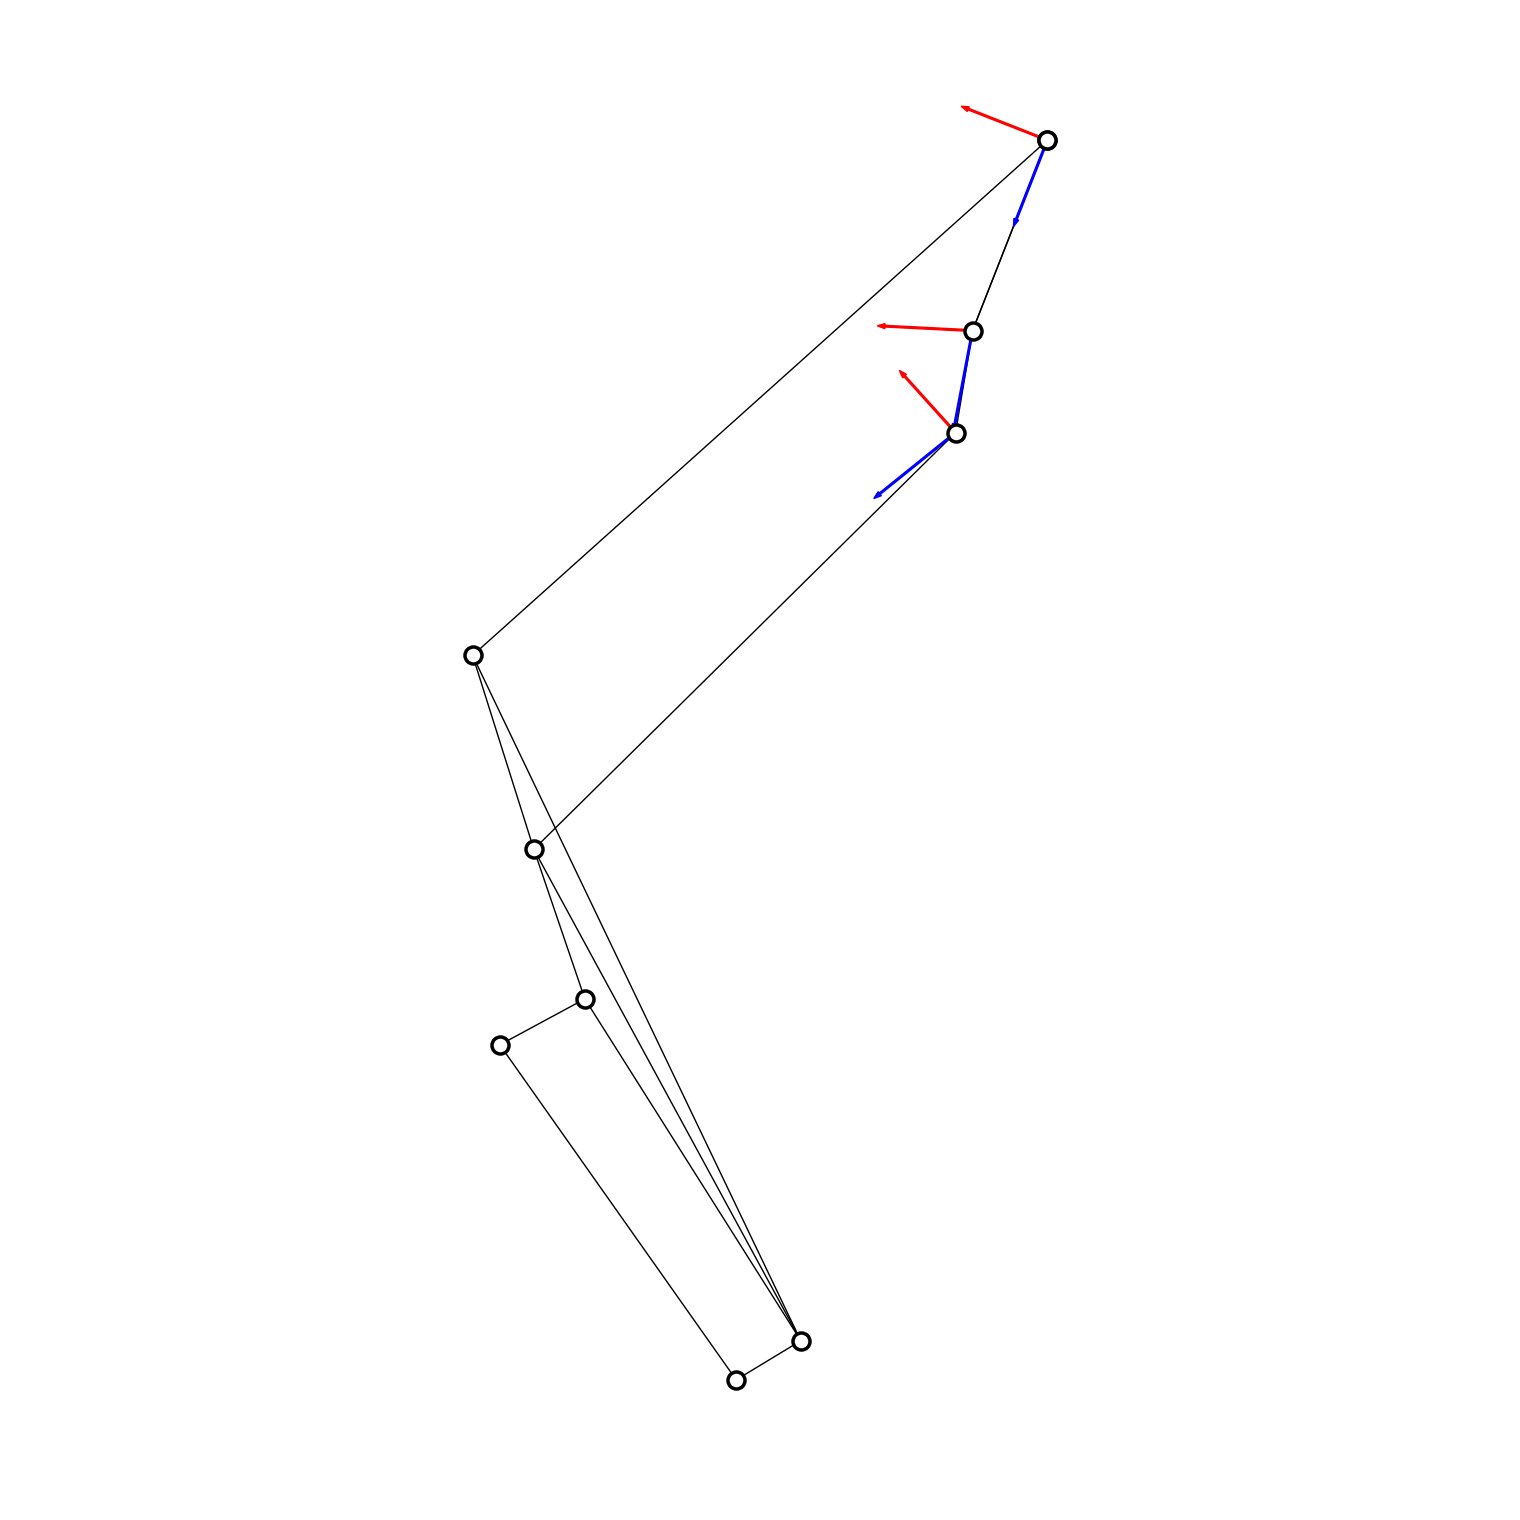

In [447]:
h_ex = np.array([ex[0],ex[1],ex[2],1])
h_ez = np.array([ez[0],ez[1],ez[2],1])

p0 = np.zeros(4)
p0[3] = 1


plt.figure(figsize=(15, 15))
nx.draw(cassie_graph, pos, node_color="w", linewidths=2.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)
v1x = H_w_b1 @ h_ex
e1z = H_w_b1 @ h_ez
p1 = H_w_b1 @ p0
plt.arrow(p1[0], p1[2],e1z[0]*0.05,e1z[2]*0.05, color="b")
plt.arrow(p1[0], p1[2],v1x[0]*0.05,v1x[2]*0.05, color="r")

e2z = H_w_b1 @ H_b1_b2 @ h_ez
v2x = H_w_b1 @ H_b1_b2 @ h_ex
p2 = H_w_b1 @ H_b1_b2 @ p0
plt.arrow(p2[0], p2[2],e2z[0]*0.05,e2z[2]*0.05, color="b")
plt.arrow(p2[0], p2[2],v2x[0]*0.05,v2x[2]*0.05, color="r")

e3z = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ h_ez
v3x = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ h_ex
p3 = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ p0
plt.arrow(p3[0], p3[2],e3z[0]*0.05,e3z[2]*0.05, color="b")
plt.arrow(p3[0], p3[2],v3x[0]*0.05,v3x[2]*0.05, color="r")

plt.axis("equal")

(-0.37349000000000004, 0.03549000000000001, -0.805545, 0.076545)

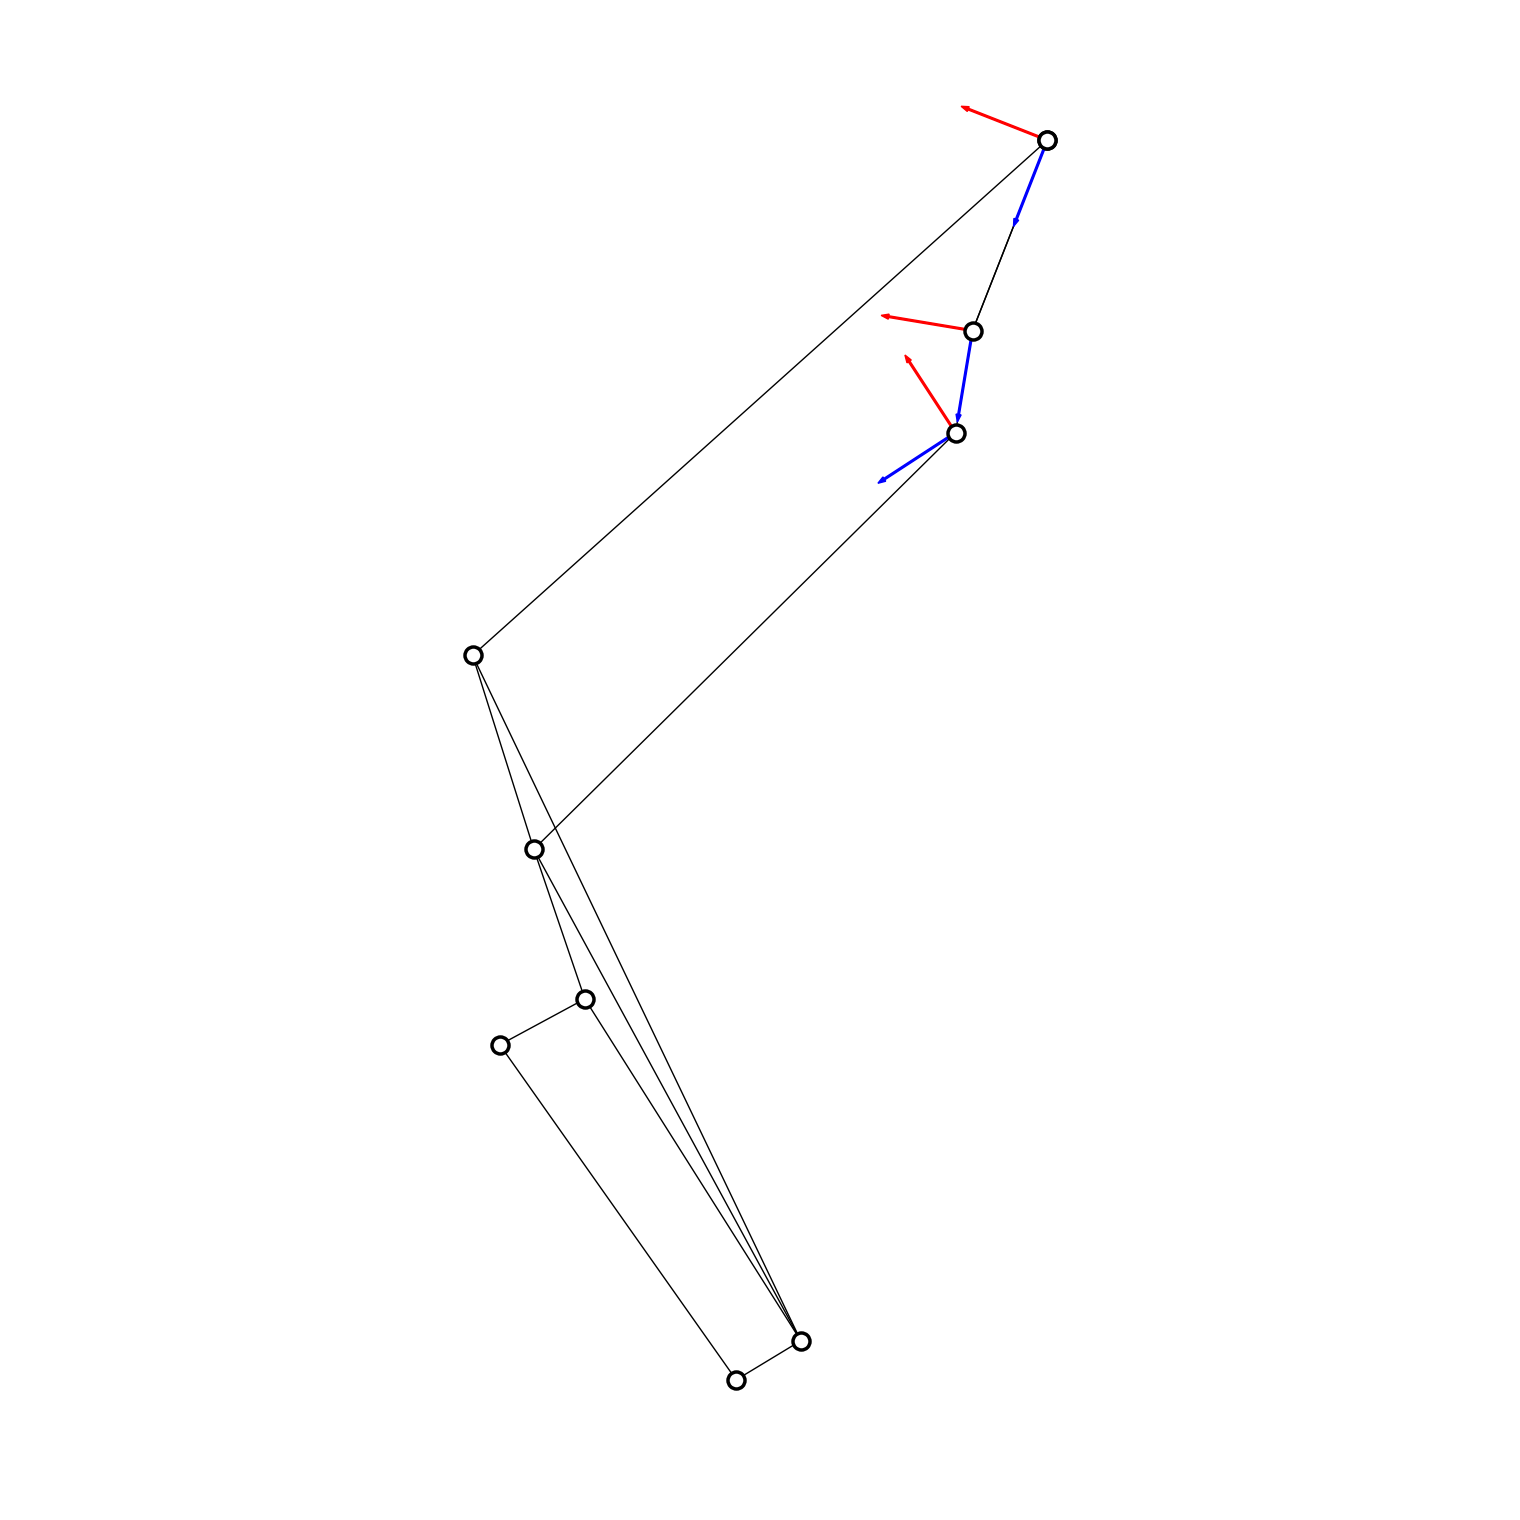

In [448]:


q1 = 0
q2 = 0
q3 = 0
plt.figure(figsize=(15, 15))
nx.draw(cassie_graph, pos, node_color="w", linewidths=2.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)
v1x = R1(q1).as_matrix() @ ex
e1z = R1(q1).as_matrix() @ ez
plt.arrow(main_branch[0].pos[0],main_branch[0].pos[2],e1z[0]*0.05,e1z[2]*0.05, color="b")
plt.arrow(main_branch[0].pos[0],main_branch[0].pos[2],v1x[0]*0.05,v1x[2]*0.05, color="r")

e2z = R1(q1).as_matrix() @ R2(q2).as_matrix() @ ez
v2x = R1(q1).as_matrix() @ R2(q2).as_matrix() @ ex
plt.arrow(main_branch[1].pos[0],main_branch[1].pos[2],e2z[0]*0.05,e2z[2]*0.05, color="b")
plt.arrow(main_branch[1].pos[0],main_branch[1].pos[2],v2x[0]*0.05,v2x[2]*0.05, color="r")

e3z = R1(q1).as_matrix() @ R2(q2).as_matrix() @ R3(q3).as_matrix() @ ez
v3x = R1(q1).as_matrix() @ R2(q2).as_matrix() @ R3(q3).as_matrix() @ ex
plt.arrow(main_branch[2].pos[0],main_branch[2].pos[2],e3z[0]*0.05,e3z[2]*0.05, color="b")
plt.arrow(main_branch[2].pos[0],main_branch[2].pos[2],v3x[0]*0.05,v3x[2]*0.05, color="r")

plt.axis("equal")